<h1>Import bibliotek</h1>

In [99]:
import torch
import torch.nn as nn
import tensorflow as tf
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import time
import os
import random

<h1>Obserwacje z poprzednich zadań</h1>

* Różne modele sprawdzają się do różnych rzeczy
* Podział zbioru na treningowy i testowy ma wpływ na nauczenie modelu
* Warto używa również zbioru walidacyjnego
* Odpowiedni dobór hiperparametrów ma znaczący wpływ na jakość modelu (warto je dobrze sprawdzić, żeby nie przeoczyć tych najlepszych dla naszego zadania)

<h1>Sprawdzenie czy możemy korzystać z GPU.</h1>

In [58]:
torch.cuda.is_available() 

False

Nie możemy bo nie mamy NVIDII :( 

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

(przydatne, gdy nie wiadomo czy możemy używać GPU)

<h1>Ustawienie seedów</h1>

In [74]:
SEED = 24
torch.manual_seed(SEED) 
np.random.seed(SEED) 
random.seed(SEED)
#więcej nie trzeba bo używamy CPU, ale dla GPU byłyby jeszcze:
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

<h1>Przygotowanie zbioru danych</h1>

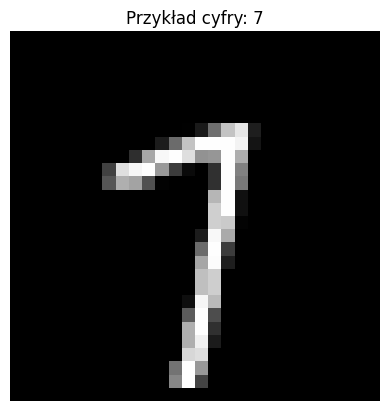

In [61]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

plt.imshow(x_train[42], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[42]}")
plt.axis('off')
plt.show()

(osobiście nie byłabym w stanie stwierdzić czy to 1 czy 7)

In [62]:
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)


Zbiór treningowy zawiera 60 000 obrazów liczb 28x28 pikseli, a testowy 10 000 obrazów o takich samych wymiarach.

In [63]:
print(y_train.shape, y_test.shape)

(60000,) (10000,)


Liczba etykiet zgadza się z liczbą obrazów.

In [64]:
print(x_train[42])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   1  26 111 195 230
   30   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  28 107 195 254 25

Piksele zawierają wartości od 0 do 255 oznaczające ich kolor w danej skali.

In [65]:
type(x_train)

numpy.ndarray

Liczby mają typ numpy array, więc trzeba je zmienić na tensory.

In [66]:
x_train = torch.from_numpy(x_train)/255
x_test = torch.from_numpy(x_test)/255
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)
print(x_train[42][:8])
print(y_train[42])

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

Od razu znormalizowałam wartości pikseli.

Utworzenie Datasetów.

In [83]:
dataset_train = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

Wydzielenie zbioru walidacyjnego.

In [80]:
val_size = 5000
train_size = len(x_train) - val_size
train_dataset, val_dataset = random_split(dataset_train, [train_size, val_size], 
                                generator=torch.Generator().manual_seed(SEED))

Utworzenie DataLoaderów.

In [88]:
BATCH = 128
trainLoader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=2)
valLoader   = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=2)
testLoader  = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=2)

In [89]:
len(train_dataset), len(val_dataset), len(test_dataset)

(55000, 5000, 10000)

Wszystko się zgadza.

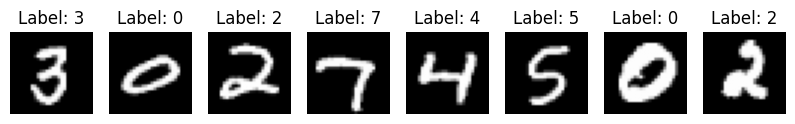

In [90]:
images, labels = next(iter(trainLoader))
images = images[:8]
labels = labels[:8]

fig, axes = plt.subplots(1, len(images), figsize=(10, 6))
for ax, img, lab in zip(axes, images, labels):
    ax.imshow(img.squeeze().numpy(), cmap="gray")
    ax.set_title(f"Label: {lab.item()}")
    ax.axis("off")
plt.show()

<h1>Baseline</h1>

Naszym baselinem będzie sieć o 2 warstwach gęstych i funkcji aktywacji ReLU.

In [131]:
class Baseline(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, output_size=10):
        super(Baseline, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.flatten(x) 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [132]:
model = Baseline().to(device)

In [133]:
EPOCHS = 5
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #CrossEntropy bo klasyfikacja

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(trainLoader, train=True)
    va_loss, va_acc = run_epoch(valLoader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Epoka {epoch:2d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Epoka  1/5 | train loss 0.4360 acc 0.8857 | val loss 0.2341 acc 0.9326
Epoka  2/5 | train loss 0.2027 acc 0.9421 | val loss 0.1740 acc 0.9492
Epoka  3/5 | train loss 0.1489 acc 0.9563 | val loss 0.1366 acc 0.9594
Epoka  4/5 | train loss 0.1174 acc 0.9666 | val loss 0.1192 acc 0.9610
Epoka  5/5 | train loss 0.0957 acc 0.9723 | val loss 0.1063 acc 0.9658
Czas treningu: 47.8s


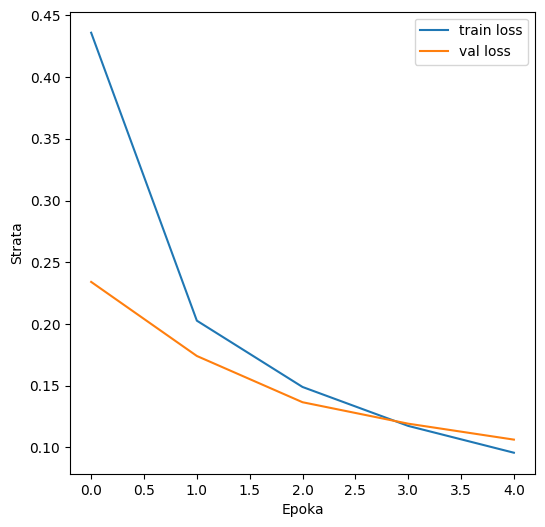

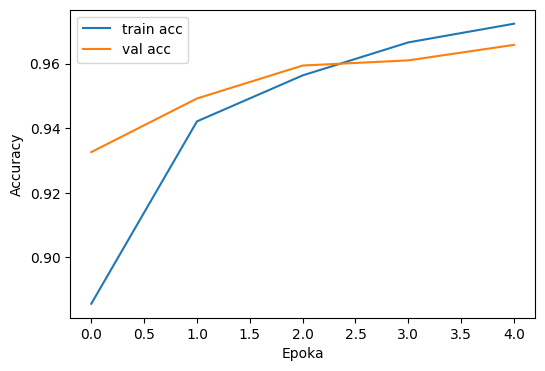

In [134]:
plt.figure(figsize=(6,6))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Widać, że model działa lepiej dla zbioru treningowego, jednak jak na baseline dla obu zbiorów są to bardzo wysokie wyniki.

Test accuracy: 0.9675


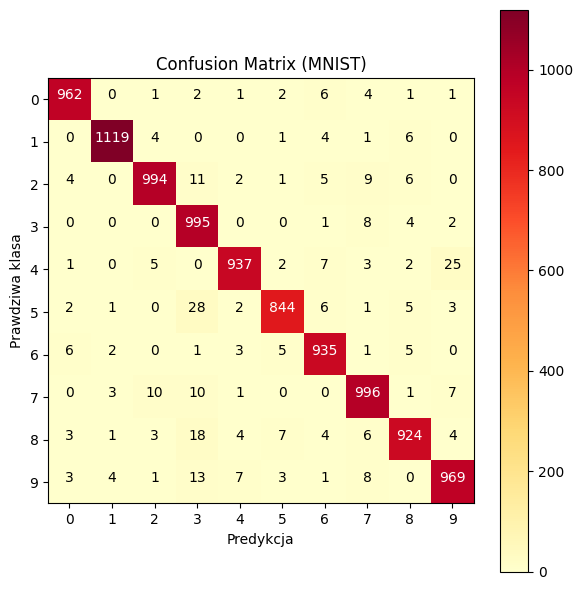

              precision    recall  f1-score   support

           0     0.9806    0.9816    0.9811       980
           1     0.9903    0.9859    0.9881      1135
           2     0.9764    0.9632    0.9698      1032
           3     0.9230    0.9851    0.9531      1010
           4     0.9791    0.9542    0.9665       982
           5     0.9757    0.9462    0.9607       892
           6     0.9649    0.9760    0.9704       958
           7     0.9605    0.9689    0.9646      1028
           8     0.9686    0.9487    0.9585       974
           9     0.9585    0.9604    0.9594      1009

    accuracy                         0.9675     10000
   macro avg     0.9678    0.9670    0.9672     10000
weighted avg     0.9679    0.9675    0.9675     10000



In [135]:
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in testLoader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap='YlOrRd')
plt.title("Confusion Matrix (MNIST)")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, digits=4))

Najczęściej mylone są liczby o podobnych kształtach jak 5 i 3 czy 9 i 4.

<h1>Własna sieć</h1>

In [148]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1) 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [149]:
model = CNN().to(device)

In [150]:
EPOCHS = 5
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(trainLoader, train=True)
    va_loss, va_acc = run_epoch(valLoader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Epoka {epoch:2d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Epoka  1/5 | train loss 0.2791 acc 0.9157 | val loss 0.0718 acc 0.9788
Epoka  2/5 | train loss 0.0782 acc 0.9766 | val loss 0.0557 acc 0.9824
Epoka  3/5 | train loss 0.0571 acc 0.9824 | val loss 0.0417 acc 0.9872
Epoka  4/5 | train loss 0.0438 acc 0.9860 | val loss 0.0331 acc 0.9888
Epoka  5/5 | train loss 0.0398 acc 0.9872 | val loss 0.0325 acc 0.9900
Czas treningu: 146.0s


Test accuracy: 0.9900


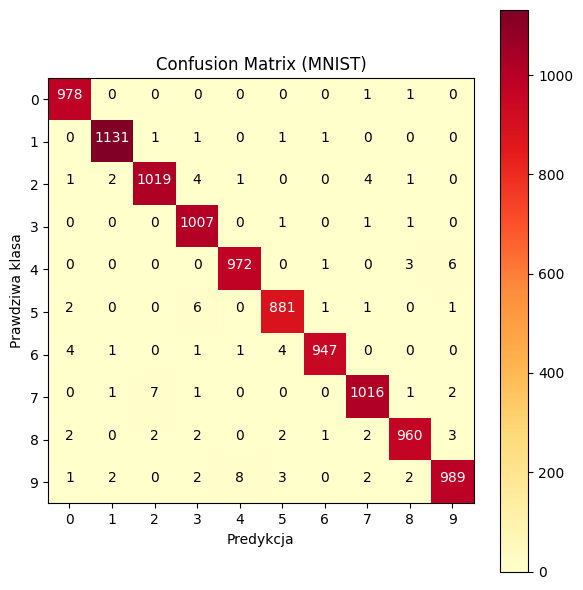

              precision    recall  f1-score   support

           0     0.9899    0.9980    0.9939       980
           1     0.9947    0.9965    0.9956      1135
           2     0.9903    0.9874    0.9888      1032
           3     0.9834    0.9970    0.9902      1010
           4     0.9898    0.9898    0.9898       982
           5     0.9877    0.9877    0.9877       892
           6     0.9958    0.9885    0.9921       958
           7     0.9893    0.9883    0.9888      1028
           8     0.9907    0.9856    0.9882       974
           9     0.9880    0.9802    0.9841      1009

    accuracy                         0.9900     10000
   macro avg     0.9900    0.9899    0.9899     10000
weighted avg     0.9900    0.9900    0.9900     10000



In [151]:
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in testLoader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap='YlOrRd')
plt.title("Confusion Matrix (MNIST)")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, digits=4))

Ten model radzi sobi lepiej niż baseline, ale spróbujemy jeszcze go poprawić.

In [153]:
class dropoutCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1) 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [154]:
model = dropoutCNN().to(device)

In [155]:
EPOCHS = 5
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(trainLoader, train=True)
    va_loss, va_acc = run_epoch(valLoader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Epoka {epoch:2d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Epoka  1/5 | train loss 0.3691 acc 0.8841 | val loss 0.0861 acc 0.9738
Epoka  2/5 | train loss 0.1282 acc 0.9619 | val loss 0.0521 acc 0.9838
Epoka  3/5 | train loss 0.0977 acc 0.9704 | val loss 0.0513 acc 0.9846
Epoka  4/5 | train loss 0.0832 acc 0.9752 | val loss 0.0392 acc 0.9884
Epoka  5/5 | train loss 0.0733 acc 0.9780 | val loss 0.0306 acc 0.9904
Czas treningu: 154.5s


Test accuracy: 0.9901


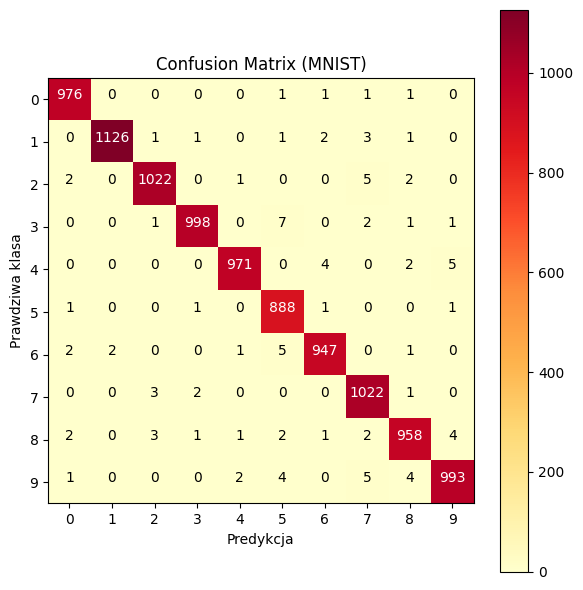

              precision    recall  f1-score   support

           0     0.9919    0.9959    0.9939       980
           1     0.9982    0.9921    0.9951      1135
           2     0.9922    0.9903    0.9913      1032
           3     0.9950    0.9881    0.9916      1010
           4     0.9949    0.9888    0.9918       982
           5     0.9780    0.9955    0.9867       892
           6     0.9906    0.9885    0.9896       958
           7     0.9827    0.9942    0.9884      1028
           8     0.9866    0.9836    0.9851       974
           9     0.9890    0.9841    0.9866      1009

    accuracy                         0.9901     10000
   macro avg     0.9899    0.9901    0.9900     10000
weighted avg     0.9901    0.9901    0.9901     10000



In [156]:
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in testLoader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap='YlOrRd')
plt.title("Confusion Matrix (MNIST)")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, digits=4))

Podnieśliśmy wynik na zbiorze testowym o 0.0001, wow

In [157]:
class batchCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.bn1  = nn.BatchNorm2d(32)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1) 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.bn1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model = batchCNN().to(device)

In [158]:
EPOCHS = 7 #uhuhu
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(trainLoader, train=True)
    va_loss, va_acc = run_epoch(valLoader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Epoka {epoch:2d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Epoka  1/7 | train loss 0.0682 acc 0.9796 | val loss 0.0344 acc 0.9894
Epoka  2/7 | train loss 0.0620 acc 0.9811 | val loss 0.0321 acc 0.9904
Epoka  3/7 | train loss 0.0603 acc 0.9815 | val loss 0.0321 acc 0.9900
Epoka  4/7 | train loss 0.0540 acc 0.9835 | val loss 0.0334 acc 0.9902
Epoka  5/7 | train loss 0.0499 acc 0.9843 | val loss 0.0270 acc 0.9924
Epoka  6/7 | train loss 0.0476 acc 0.9854 | val loss 0.0259 acc 0.9928
Epoka  7/7 | train loss 0.0461 acc 0.9856 | val loss 0.0262 acc 0.9924
Czas treningu: 209.6s


Test accuracy: 0.9934


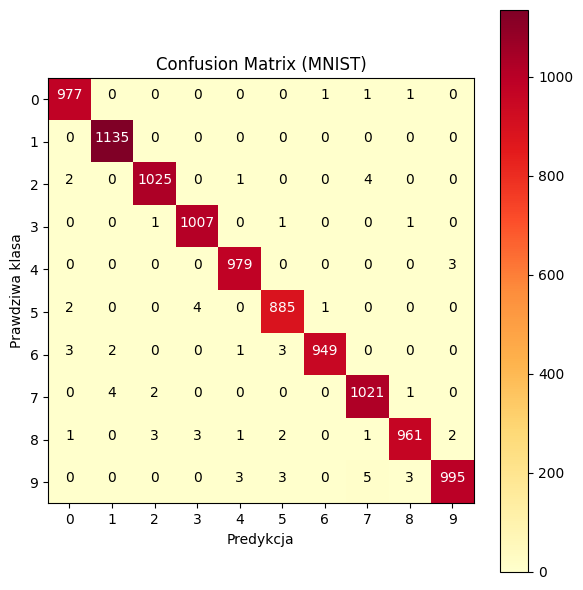

              precision    recall  f1-score   support

           0     0.9919    0.9969    0.9944       980
           1     0.9947    1.0000    0.9974      1135
           2     0.9942    0.9932    0.9937      1032
           3     0.9931    0.9970    0.9951      1010
           4     0.9939    0.9969    0.9954       982
           5     0.9899    0.9922    0.9910       892
           6     0.9979    0.9906    0.9942       958
           7     0.9893    0.9932    0.9913      1028
           8     0.9938    0.9867    0.9902       974
           9     0.9950    0.9861    0.9905      1009

    accuracy                         0.9934     10000
   macro avg     0.9934    0.9933    0.9933     10000
weighted avg     0.9934    0.9934    0.9934     10000



In [159]:
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in testLoader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap='YlOrRd')
plt.title("Confusion Matrix (MNIST)")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, digits=4))

BatchNorm zrobiło większą różnicę niż Dropout, od początku treningu widać lepsze wyniki niż w poprzednim modelu, zobazcmy czy da się zrobić jeszcze lepsze bez przetrenowania.

In [164]:
class megaCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.bn1  = nn.BatchNorm2d(64)
        self.bn2  = nn.BatchNorm2d(64)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, 64)
        self.fc3  = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1) 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.bn2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Dodana została dodatkowa warstwa w pełni połączona i batchnorm.

In [165]:
model = megaCNN().to(device)

In [166]:
EPOCHS = 7
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(trainLoader, train=True)
    va_loss, va_acc = run_epoch(valLoader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Epoka {epoch:2d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Epoka  1/7 | train loss 0.2524 acc 0.9228 | val loss 0.0507 acc 0.9846
Epoka  2/7 | train loss 0.0931 acc 0.9722 | val loss 0.0372 acc 0.9888
Epoka  3/7 | train loss 0.0775 acc 0.9769 | val loss 0.0350 acc 0.9894
Epoka  4/7 | train loss 0.0657 acc 0.9796 | val loss 0.0308 acc 0.9904
Epoka  5/7 | train loss 0.0613 acc 0.9818 | val loss 0.0284 acc 0.9912
Epoka  6/7 | train loss 0.0552 acc 0.9825 | val loss 0.0285 acc 0.9914
Epoka  7/7 | train loss 0.0507 acc 0.9851 | val loss 0.0272 acc 0.9918
Czas treningu: 213.8s


Test accuracy: 0.9926


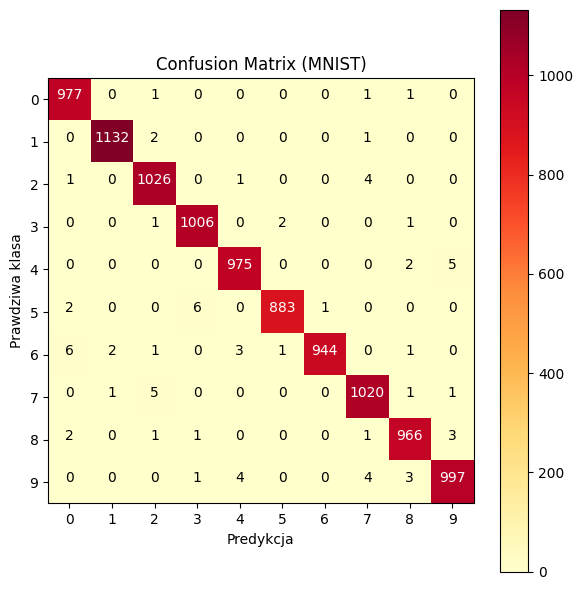

              precision    recall  f1-score   support

           0     0.9889    0.9969    0.9929       980
           1     0.9974    0.9974    0.9974      1135
           2     0.9894    0.9942    0.9918      1032
           3     0.9921    0.9960    0.9941      1010
           4     0.9919    0.9929    0.9924       982
           5     0.9966    0.9899    0.9933       892
           6     0.9989    0.9854    0.9921       958
           7     0.9893    0.9922    0.9908      1028
           8     0.9908    0.9918    0.9913       974
           9     0.9911    0.9881    0.9896      1009

    accuracy                         0.9926     10000
   macro avg     0.9926    0.9925    0.9925     10000
weighted avg     0.9926    0.9926    0.9926     10000



In [168]:
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in testLoader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap='YlOrRd')
plt.title("Confusion Matrix (MNIST)")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, digits=4))

Wyszło jednak nie tak mega i poptrzednia jest lepsza - więcej nie zawsze znaczy lepiej - więc werdyktem najlepszego co teraz wyklikam jest batchCNN

<h1>Wnioski i obserwacje</h1>

* Liczba epok ma wpływ na nauczenie modelu - jej zwiększenie może prowadzić do przetrenowania, ale zbyt mała liczba powoduje niedouczenie
* Zwiększenie wartości  Dropout zmniejsza przeuczenie modelu, jednak jej zbyt duża wartość może powodować niedouczenie
* BatchNorm stabilizuje trening przez normalizację w jego trakcie
* Tak jak w poprzednim zadaniu wartości używane w konkretnych warstwach mają duży wpływ na działanie modelu i ich dobór w duzej mierze zależy od danych z jakimi mamy do czynienia.